# PEZ Grid Search Results Analysis (Lambda Variation)

This notebook analyzes PEZ grid search results, focusing on lambda variation with multiple learning rates.


In [31]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [32]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test"
non_adv_dir = os.path.join(base_dir, "adversarial_false")
adv_dir = os.path.join(base_dir, "adversarial_true")

print(f"Results directory: {base_dir}")
print(f"Non-adversarial directory: {non_adv_dir}")
print(f"Adversarial directory: {adv_dir}")


Results directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test
Non-adversarial directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test/adversarial_false
Adversarial directory: /mnt/polished-lake/home/annabelma/other/results_fixed/pez_final_test/adversarial_true


In [ ]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_lambda_{lambda}_lr_{lr}_promptlen_{prompt_length}.json
        filename = os.path.basename(filepath)
        # Try new format first (with promptlen)
        match = re.match(r"history_lambda_([0-9.]+)_lr_([0-9.e-]+)_promptlen_([0-9]+)\.json", filename)
        if match:
            lambda_val = float(match.group(1))
            lr_val = float(match.group(2))
            prompt_length = int(match.group(3))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (lambda_val, lr_val, prompt_length)
            histories[key] = history
            print(f"Loaded: lambda={lambda_val}, lr={lr_val}, prompt_length={prompt_length}")
        else:
            # Try old format (without promptlen) for backward compatibility
            match_old = re.match(r"history_lambda_([0-9.]+)_lr_([0-9.e-]+)\.json", filename)
            if match_old:
                lambda_val = float(match_old.group(1))
                lr_val = float(match_old.group(2))
                
                with open(filepath, 'r') as f:
                    history = json.load(f)
                
                # Use prompt_length from history if available, otherwise default to 10
                prompt_length = history.get('prompt_length', 10)
                key = (lambda_val, lr_val, prompt_length)
                histories[key] = history
                print(f"Loaded (old format): lambda={lambda_val}, lr={lr_val}, prompt_length={prompt_length}")
    
    return histories


In [ ]:
# Load histories
print("Loading non-adversarial histories...")
non_adv_histories = load_all_histories(non_adv_dir)
print(f"\nNon-adversarial: {len(non_adv_histories)} runs")

# Check available prompt lengths
if non_adv_histories:
    prompt_lengths = sorted(set(k[2] for k in non_adv_histories.keys()))
    print(f"Available prompt lengths: {prompt_lengths}")

print("\n" + "=" * 80)
print("Loading adversarial histories...")
adv_histories = {}
if os.path.exists(adv_dir):
    adv_histories = load_all_histories(adv_dir)
    print(f"\nAdversarial: {len(adv_histories)} runs")
    if adv_histories:
        prompt_lengths_adv = sorted(set(k[2] for k in adv_histories.keys()))
        print(f"Available prompt lengths: {prompt_lengths_adv}")
else:
    print(f"Adversarial directory not found: {adv_dir}")

# Helper function to filter histories by prompt length
def filter_by_prompt_length(histories, prompt_length=None):
    """Filter histories by prompt length. If None, returns all."""
    if prompt_length is None:
        return histories
    return {(lam, lr, pl): h for (lam, lr, pl), h in histories.items() if pl == prompt_length}

# For analysis, we can filter to a specific prompt length or analyze all
# Default: use prompt_length=10 if available, otherwise use the first available
default_prompt_length = None
if non_adv_histories:
    available_pls = sorted(set(k[2] for k in non_adv_histories.keys()))
    if 10 in available_pls:
        default_prompt_length = 10
    else:
        default_prompt_length = available_pls[0] if available_pls else None
    print(f"\nDefault prompt length for analysis: {default_prompt_length}")

# Optionally filter to default prompt length for focused analysis
# Uncomment the following lines to filter to a specific prompt length:
# non_adv_histories = filter_by_prompt_length(non_adv_histories, default_prompt_length)
# adv_histories = filter_by_prompt_length(adv_histories, default_prompt_length)


Loading non-adversarial histories...
Loaded: lambda=0.01, lr=0.0001
Loaded: lambda=0.01, lr=0.001
Loaded: lambda=0.01, lr=0.01
Loaded: lambda=0.0, lr=0.0001
Loaded: lambda=0.0, lr=0.001
Loaded: lambda=0.0, lr=0.01
Loaded: lambda=0.1, lr=0.0001
Loaded: lambda=0.1, lr=0.001
Loaded: lambda=0.1, lr=0.01
Loaded: lambda=0.25, lr=0.0001
Loaded: lambda=0.25, lr=0.001
Loaded: lambda=0.25, lr=0.01
Loaded: lambda=0.5, lr=0.0001
Loaded: lambda=0.5, lr=0.001
Loaded: lambda=0.5, lr=0.01
Loaded: lambda=0.75, lr=0.0001
Loaded: lambda=0.75, lr=0.001
Loaded: lambda=0.75, lr=0.01
Loaded: lambda=1.0, lr=0.0001
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.01

Non-adversarial: 21 runs

Loading adversarial histories...
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.1
Loaded: lambda=1.0, lr=1e-06

Adversarial: 3 runs


In [ ]:
def plot_learning_curves(histories, title_prefix="", max_epochs=None, select_best_lr=True):
    """Plot learning curves for PEZ, grouped by learning rate.
    
    Args:
        histories: Dictionary of histories with keys (lambda, lr, prompt_length)
        title_prefix: Prefix for plot titles
        max_epochs: Maximum number of epochs to plot (None = plot all)
        select_best_lr: If True, select LR with best final acc for each lambda (across all prompt lengths)
    """
    
    if not histories:
        print("No histories to plot")
        return []
    
    # If select_best_lr, filter to keep only the best LR for each lambda
    if select_best_lr:
        # Group by lambda (and optionally prompt_length)
        lambda_values = sorted(set(k[0] for k in histories.keys()))
        filtered_histories = {}
        
        for lam in lambda_values:
            # Get all histories for this lambda (across all prompt lengths and LRs)
            lam_histories = {(lam_val, lr, pl): h for (lam_val, lr, pl), h in histories.items() if lam_val == lam}
            
            # Select LR with BEST final accuracy (across all prompt lengths)
            best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
        
        histories = filtered_histories
        print(f"Selected best LR for each lambda")
    
    # Group by learning rate (since we're varying lambda)
    lr_values = sorted(set(k[1] for k in histories.keys()))
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    
    figs = []
    
    for lr in lr_values:
        # Filter histories for this learning rate
        lr_histories = {(lam, lr_val, pl): h for (lam, lr_val, pl), h in histories.items() if lr_val == lr}
        
        if not lr_histories:
            continue
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"{title_prefix}PEZ Learning Curves - LR={lr:.0e}", fontsize=16, fontweight='bold')
        
        # Plot 1: Training Task Loss
        ax1 = axes[0, 0]
        for (lam, lr_val, pl), history in sorted(lr_histories.items()):
            if 'train_task' in history:
                data = history['train_task'][:max_epochs] if max_epochs else history['train_task']
                epochs = range(1, len(data) + 1)
                ax1.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Task Loss')
        ax1.set_title(f'PEZ: Training Task Loss (LR={lr:.0e})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Loss
        ax2 = axes[0, 1]
        for (lam, lr_val, pl), history in sorted(lr_histories.items()):
            data = history['val_loss'][:max_epochs] if max_epochs else history['val_loss']
            epochs = range(1, len(data) + 1)
            ax2.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title(f'PEZ: Validation Loss (LR={lr:.0e})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Accuracy
        ax3 = axes[1, 0]
        for (lam, lr_val, pl), history in sorted(lr_histories.items()):
            data = history['val_acc'][:max_epochs] if max_epochs else history['val_acc']
            epochs = range(1, len(data) + 1)
            ax3.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Accuracy')
        ax3.set_title(f'PEZ: Validation Accuracy (LR={lr:.0e})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Perplexity
        ax4 = axes[1, 1]
        for (lam, lr_val, pl), history in sorted(lr_histories.items()):
            if 'prompt_ppl_ppx' in history:
                data = history['prompt_ppl_ppx'][:max_epochs] if max_epochs else history['prompt_ppl_ppx']
                epochs = range(1, len(data) + 1)
                ax4.plot(epochs, data, marker='o', label=f"lambda={lam}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Prompt Perplexity')
        ax4.set_title(f'PEZ: Prompt Perplexity (LR={lr:.0e})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial PEZ learning curves (best LR selected)...
Selected best LR for each lambda


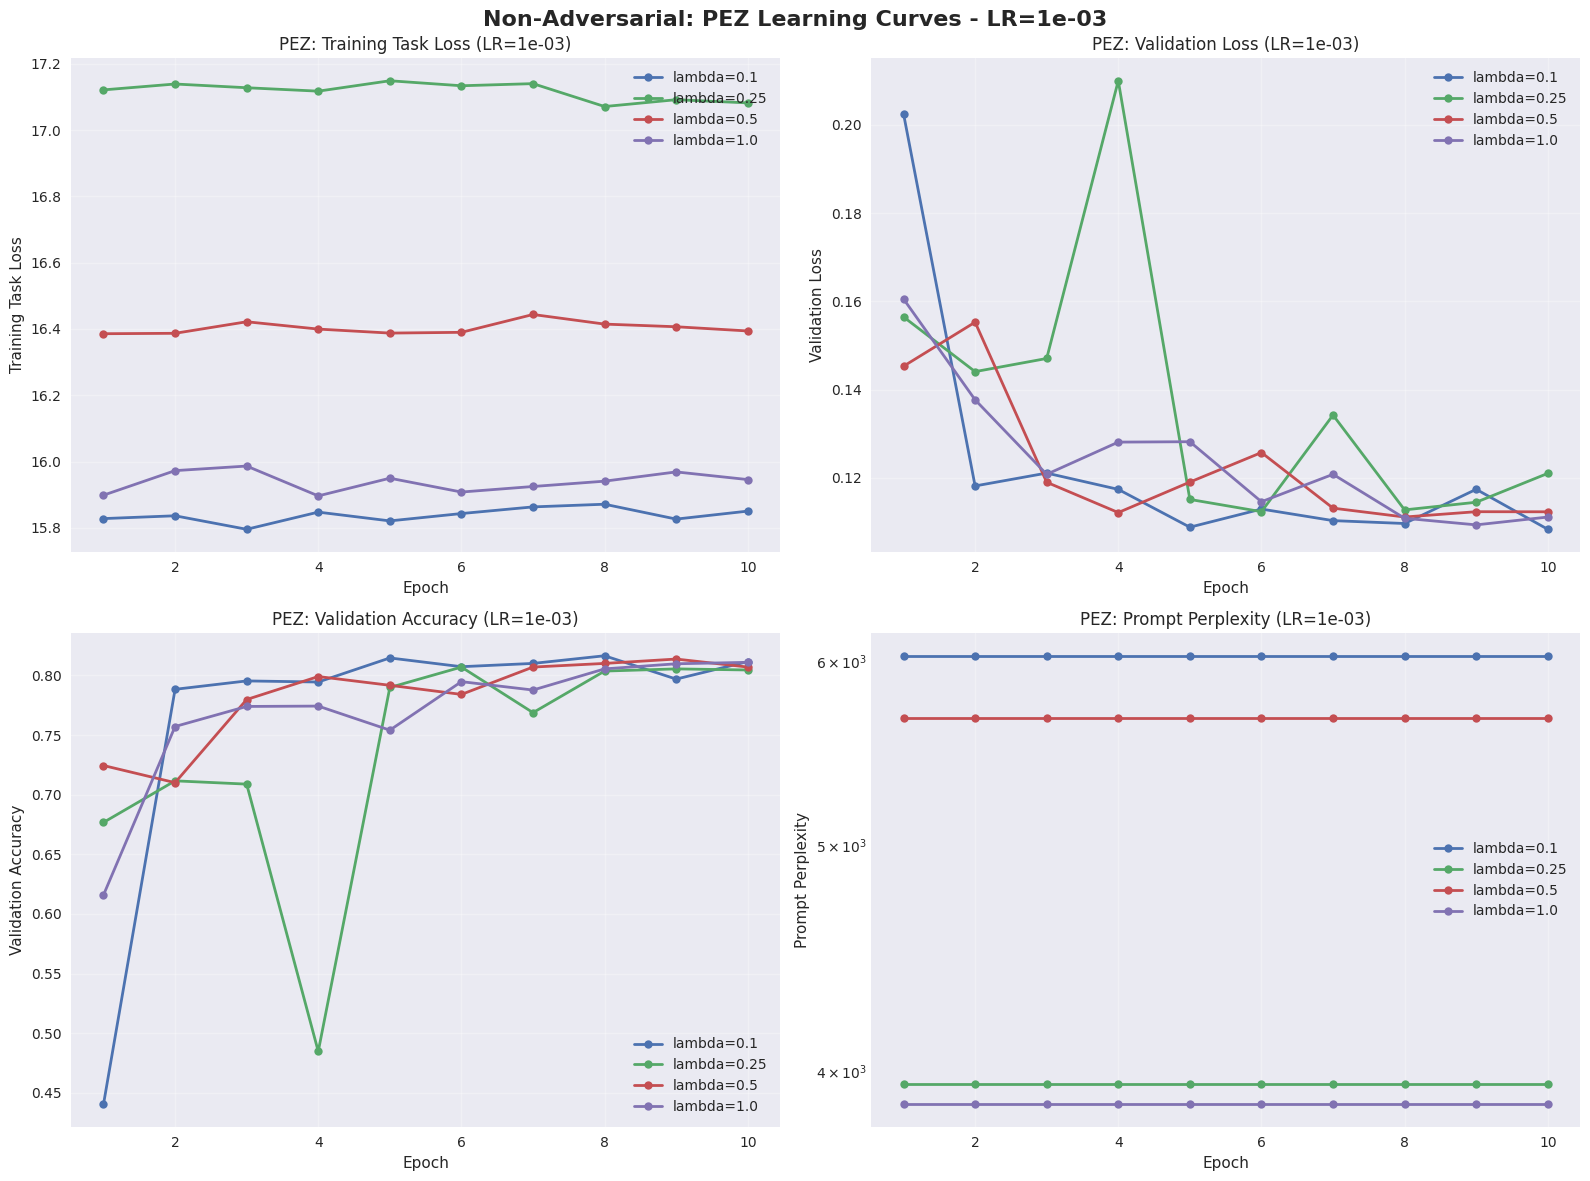

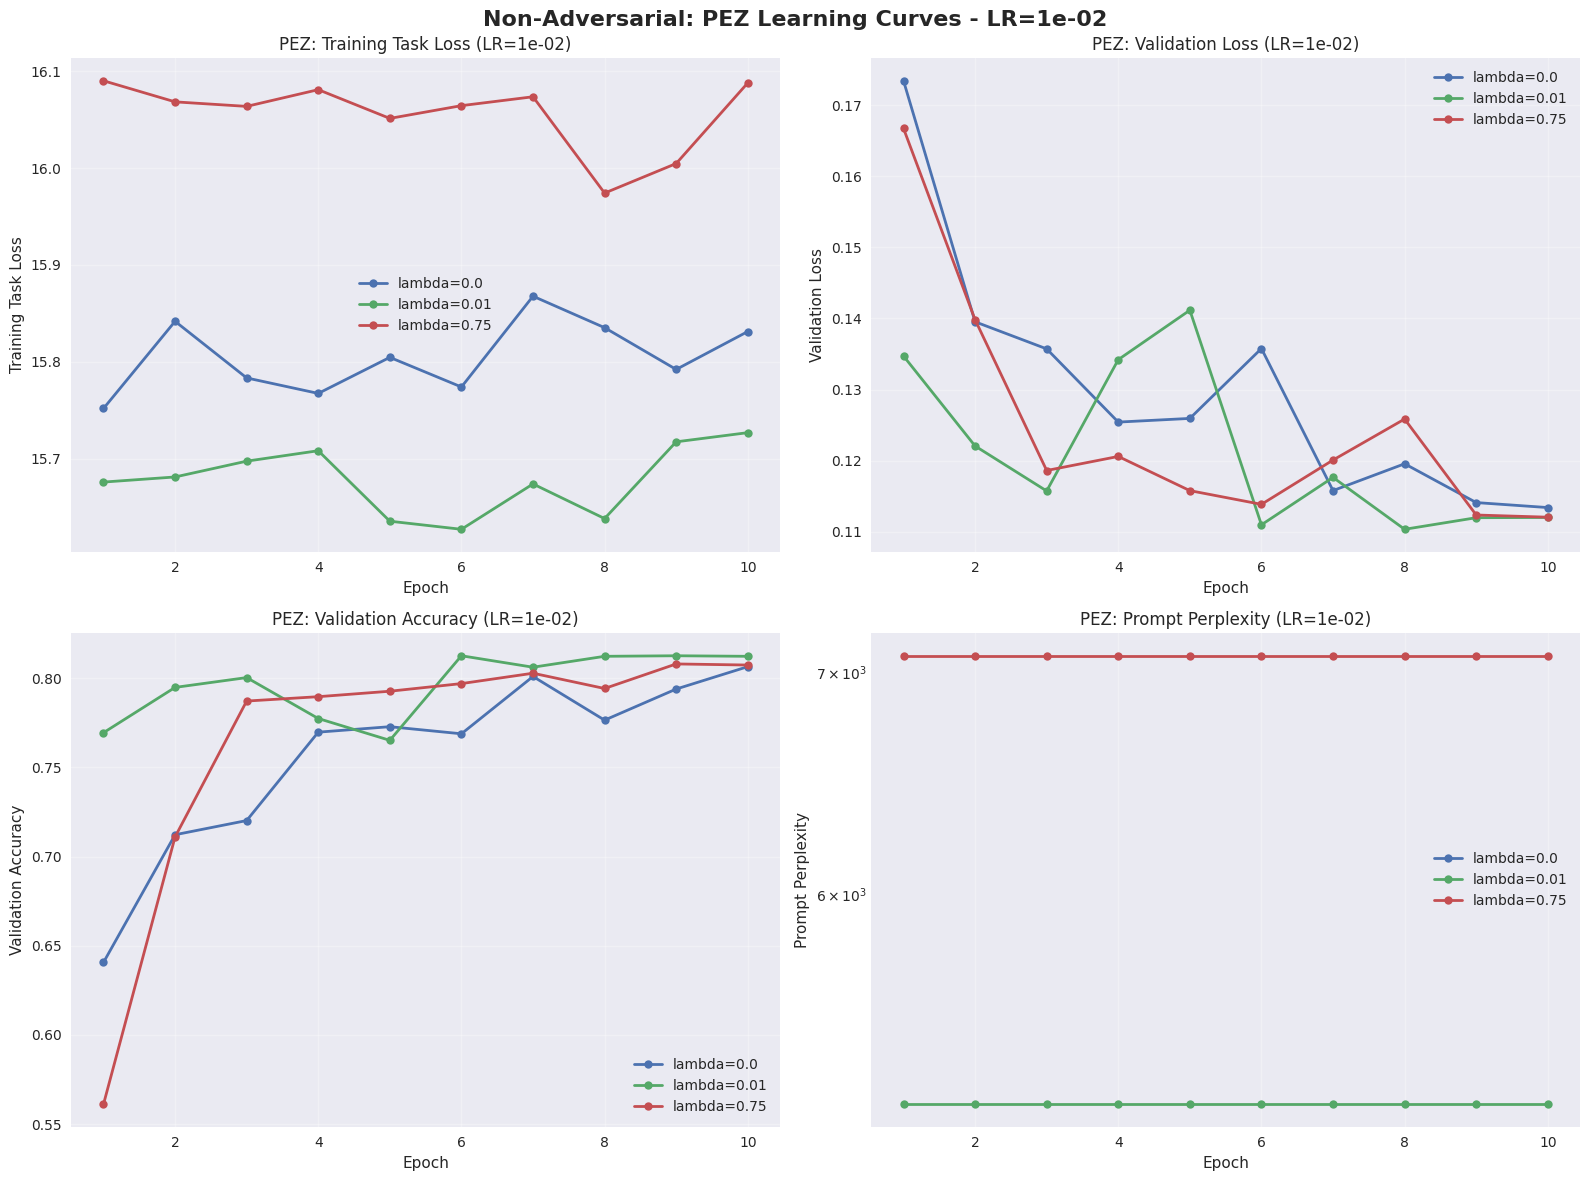

In [24]:
# Plot non-adversarial learning curves (select best LR for each lambda)
print("Plotting non-adversarial PEZ learning curves (best LR selected)...")
if non_adv_histories:
    figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ", select_best_lr=True)
    for fig in figs_non_adv:
        plt.show()
else:
    print("No non-adversarial PEZ histories found")


Plotting non-adversarial PEZ learning curves (one plot per LR)...


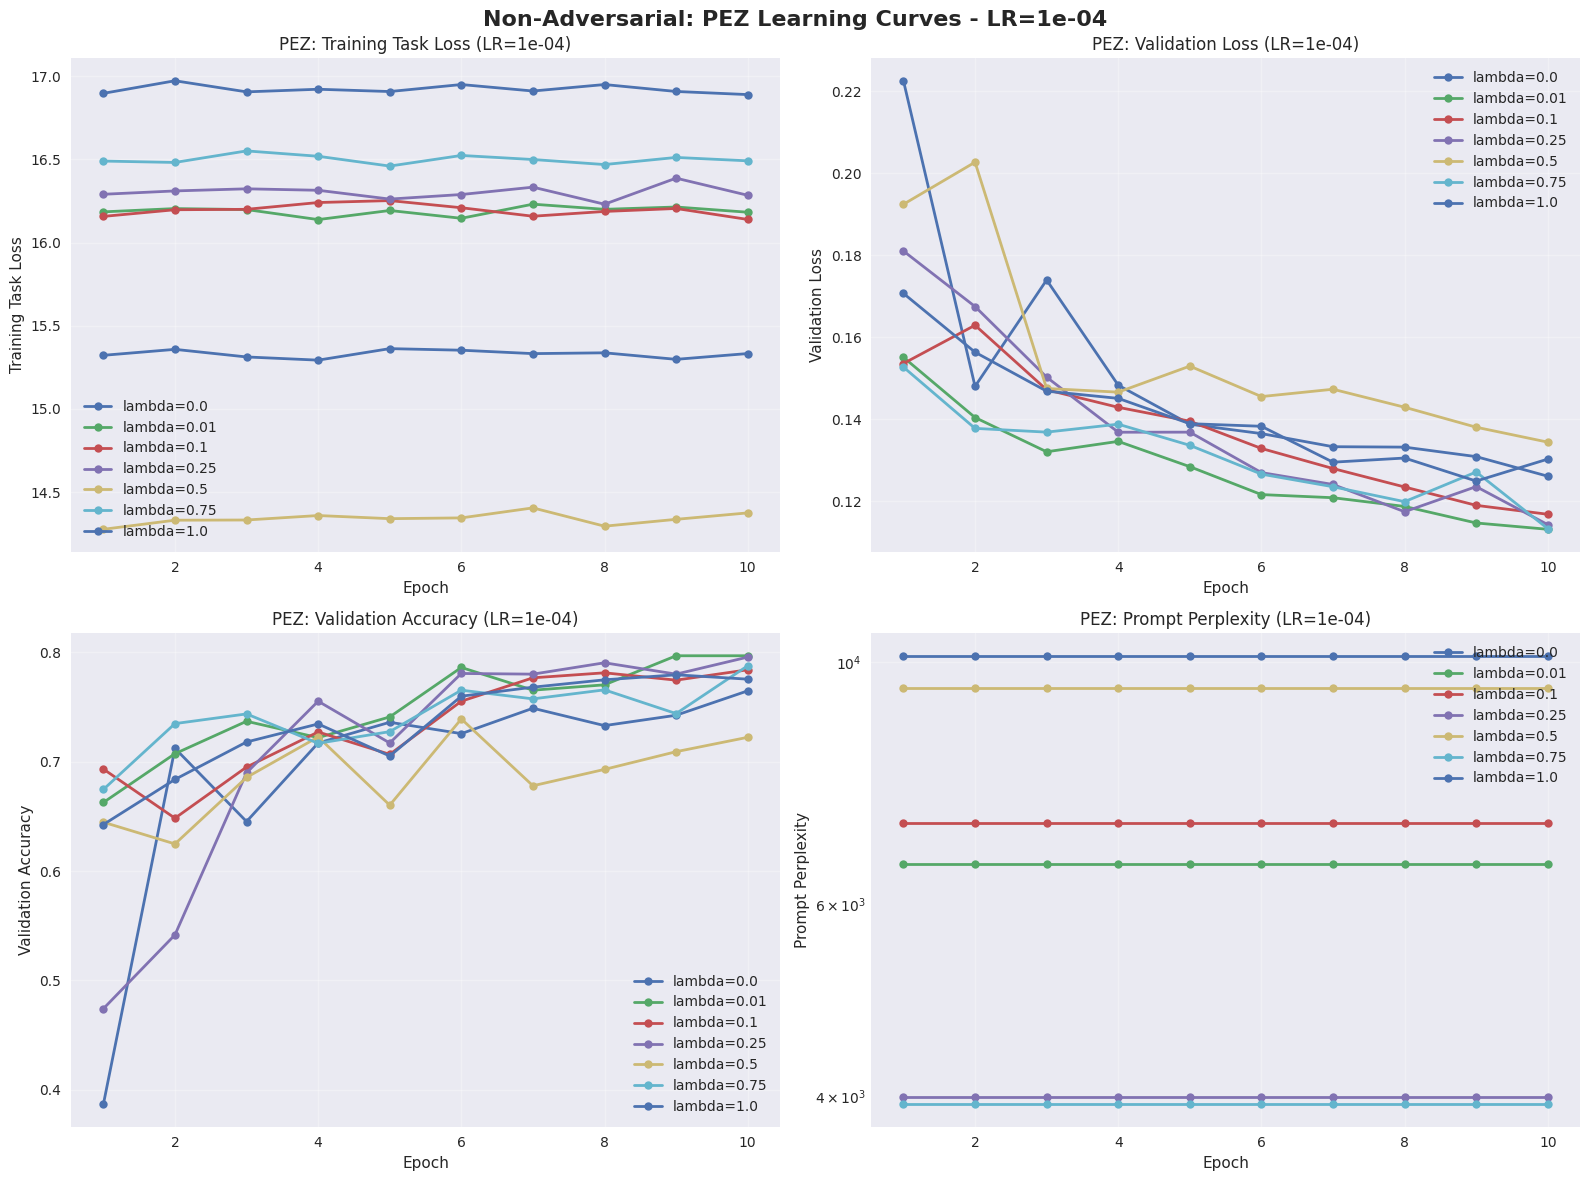

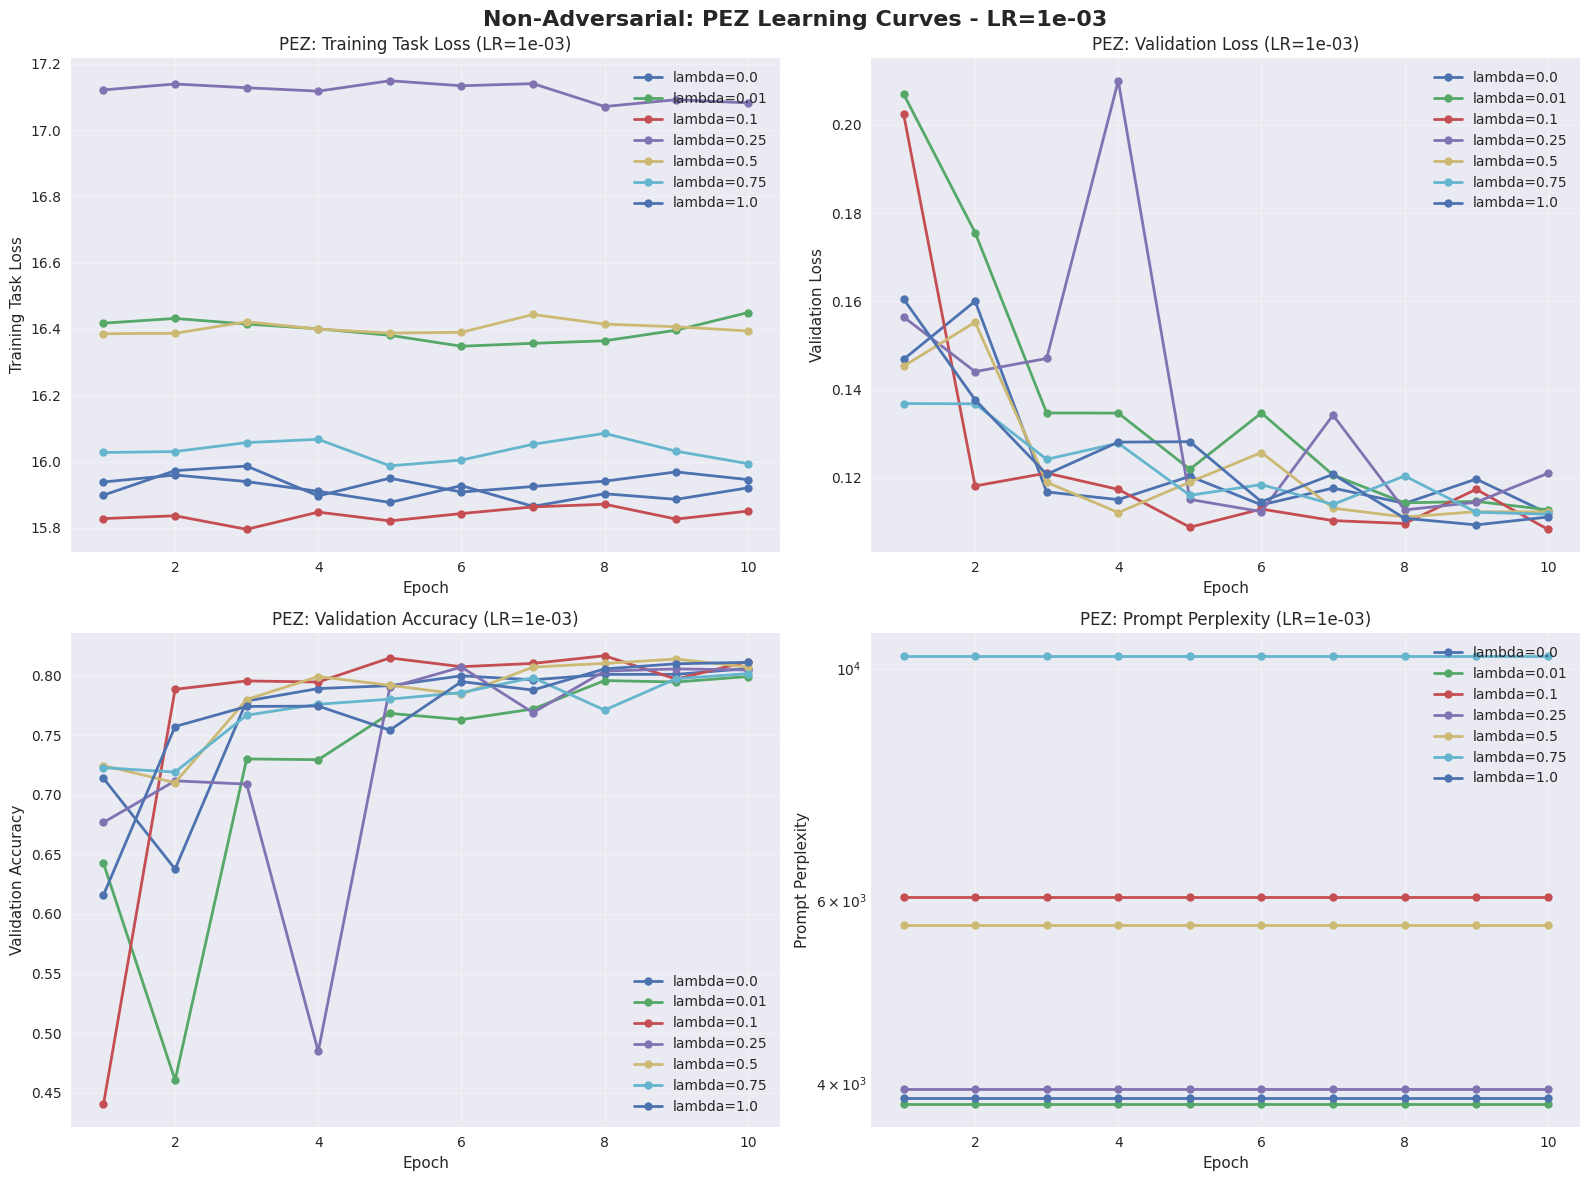

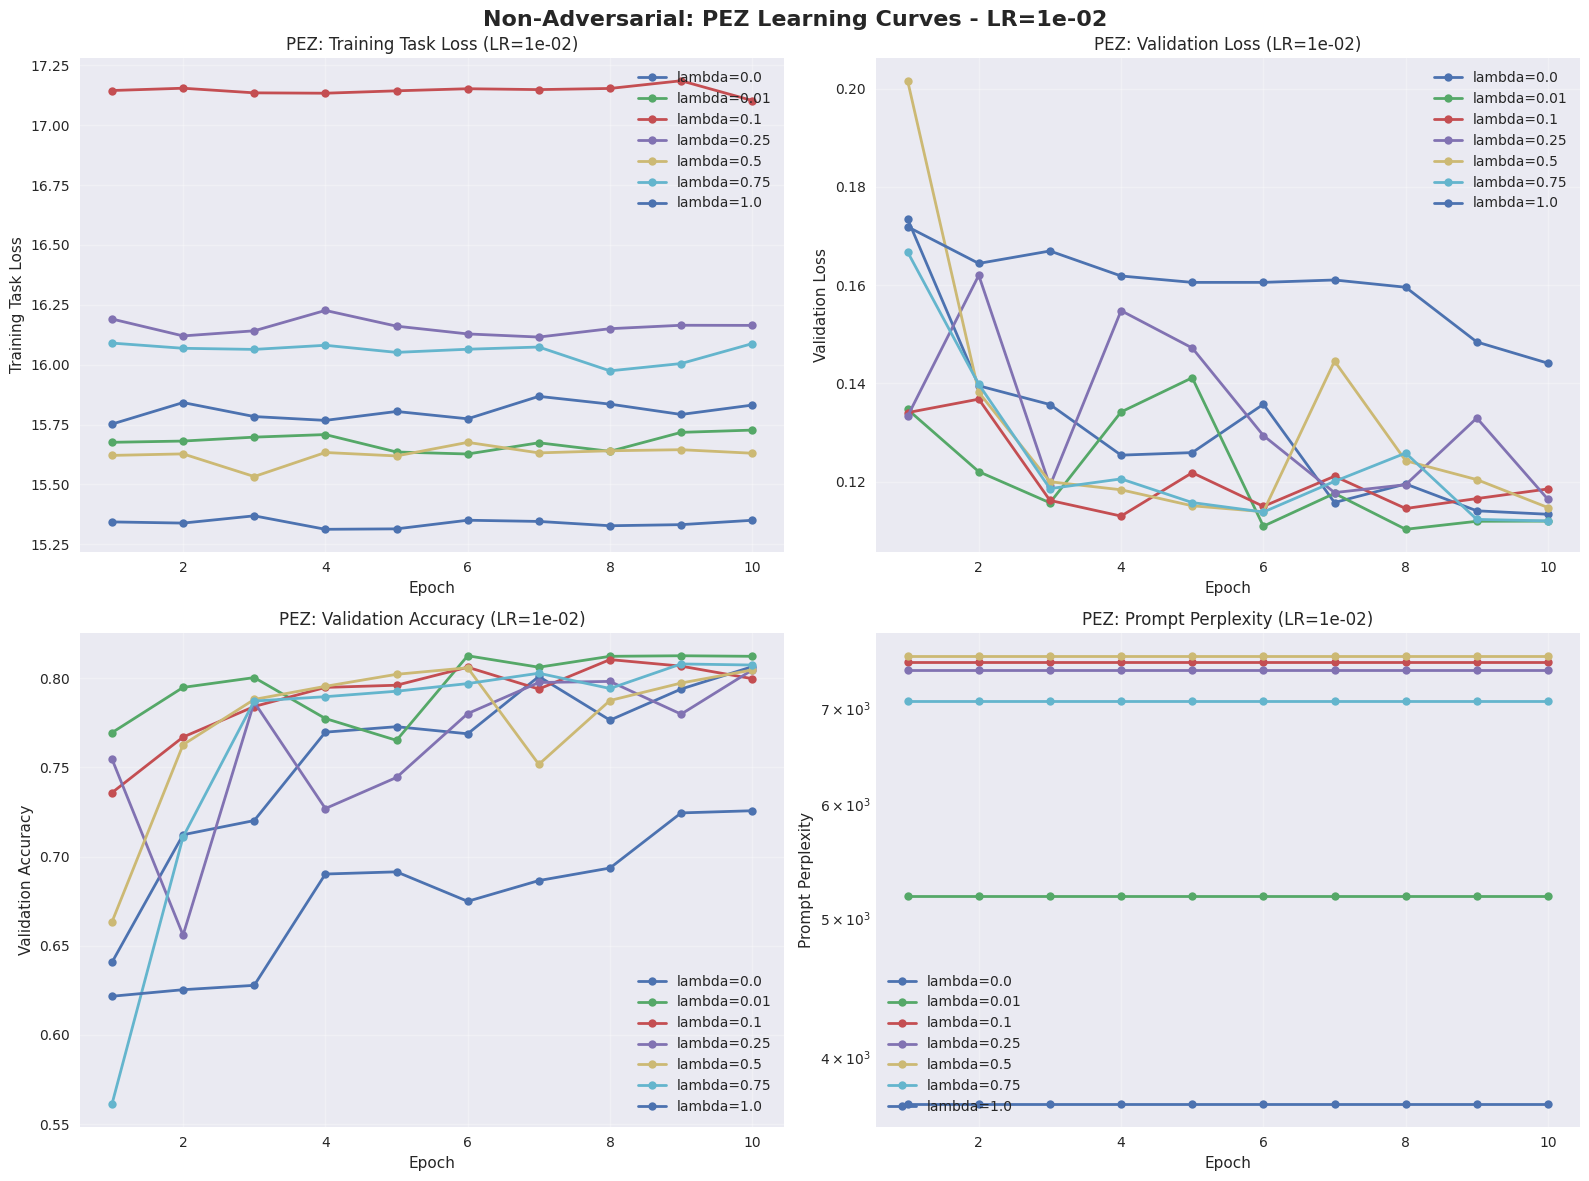

In [25]:
# Plot non-adversarial learning curves (one plot per LR, showing all lambdas)
print("Plotting non-adversarial PEZ learning curves (one plot per LR)...")
if non_adv_histories:
    figs_non_adv_all = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ", select_best_lr=False)
    for fig in figs_non_adv_all:
        plt.show()
else:
    print("No non-adversarial PEZ histories found")


In [ ]:
# Summary table
print("\n" + "=" * 80)
print("PEZ: SUMMARY TABLE")
print("=" * 80)

summary_data = []

for (lam, lr, pl), history in sorted(non_adv_histories.items()):
    best_val_acc = max(history['val_acc'])
    final_val_acc = history['val_acc'][-1]
    best_true_acc = max(history['val_acc_true'])
    best_false_acc = max(history['val_acc_false'])
    final_prompt_ppl = history['prompt_ppl_ppx'][-1] if 'prompt_ppl_ppx' in history else None
    
    summary_data.append({
        'Lambda': lam,
        'Learning Rate': f"{lr:.0e}",
        'Prompt Length': pl,
        'Best Val Acc': best_val_acc,
        'Final Val Acc': final_val_acc,
        'Best True Acc': best_true_acc,
        'Best False Acc': best_false_acc,
        'Final Prompt PPL': final_prompt_ppl
    })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))



PEZ: SUMMARY TABLE
 Lambda Learning Rate  Best Val Acc  Final Val Acc  Best True Acc  Best False Acc  Final Prompt PPL
   0.00         1e-04      0.764832       0.764832       0.997541        0.993533          0.000000
   0.00         1e-03      0.805810       0.805810       0.981308        0.921584          0.000000
   0.00         1e-02      0.806422       0.806422       0.998524        0.810833          0.000000
   0.01         1e-04      0.796942       0.796942       0.995081        0.636217       6532.537036
   0.01         1e-03      0.799083       0.799083       0.998032        0.957963       3818.711215
   0.01         1e-02      0.812538       0.812232       0.907526        0.852061       5184.598711
   0.10         1e-04      0.784098       0.784098       0.995573        0.581245       7119.216930
   0.10         1e-03      0.816514       0.811621       0.898672        0.991108       6031.304430
   0.10         1e-02      0.810398       0.799694       0.967044        0.78658

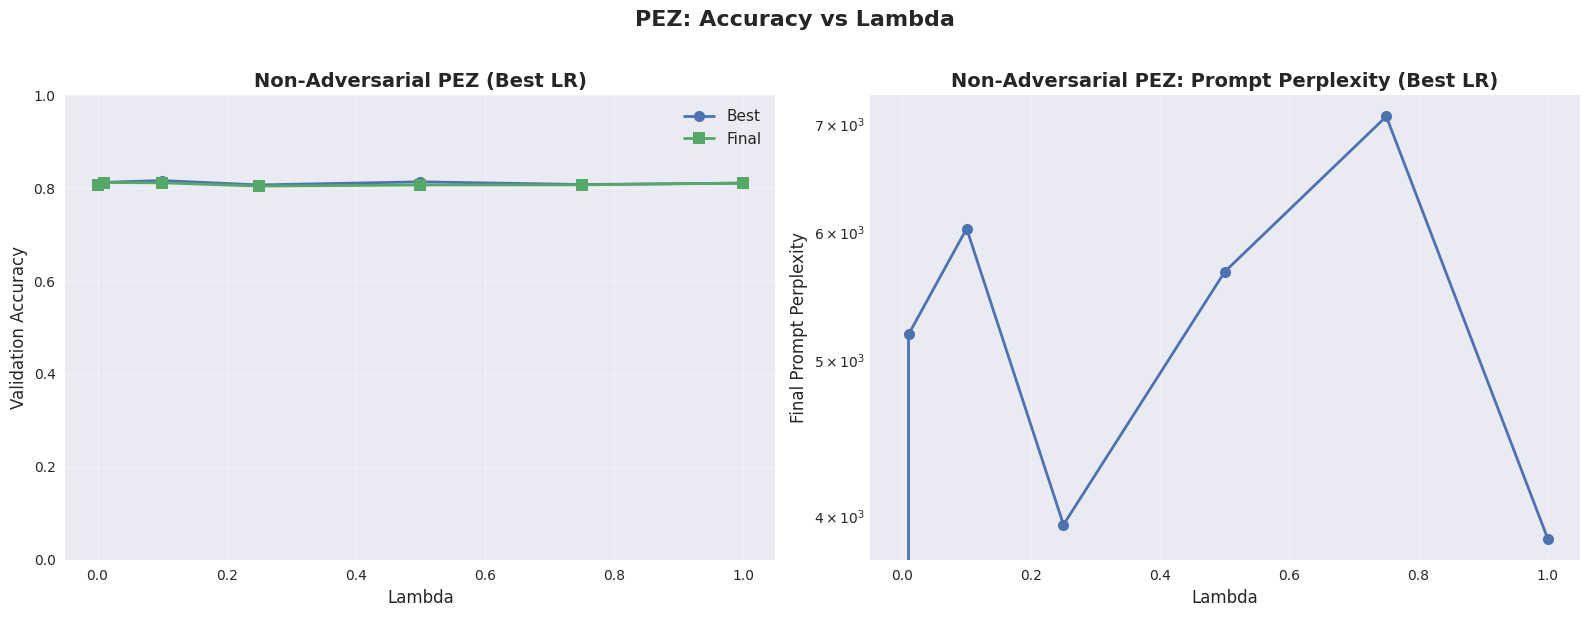

In [ ]:
# Comparison plot: Best accuracy vs Lambda
# For non-adversarial: use LR with best final accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('PEZ: Accuracy vs Lambda', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial
if non_adv_histories:
    ax1 = axes[0]
    lambda_values = sorted(set(k[0] for k in non_adv_histories.keys()))
    best_accs = []
    final_accs = []
    for lam in lambda_values:
        # Get all histories for this lambda (across all prompt lengths and LRs)
        lam_histories = {(lam_val, lr, pl): h for (lam_val, lr, pl), h in non_adv_histories.items() if lam_val == lam}
        # Select LR with BEST final accuracy (across all prompt lengths)
        best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        best_accs.append(max(history['val_acc']))
        final_accs.append(history['val_acc'][-1])
    
    ax1.plot(lambda_values, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax1.plot(lambda_values, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax1.set_xlabel('Lambda', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Non-Adversarial PEZ (Best LR)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

# Prompt Perplexity vs Lambda
if non_adv_histories:
    ax2 = axes[1]
    lambda_values = sorted(set(k[0] for k in non_adv_histories.keys()))
    final_ppls = []
    for lam in lambda_values:
        # Get all histories for this lambda (across all prompt lengths and LRs)
        lam_histories = {(lam_val, lr, pl): h for (lam_val, lr, pl), h in non_adv_histories.items() if lam_val == lam}
        # Select LR with BEST final accuracy (across all prompt lengths)
        best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
        history = best_key[1]
        final_ppls.append(history['prompt_ppl_ppx'][-1] if 'prompt_ppl_ppx' in history else None)
    
    ax2.plot(lambda_values, final_ppls, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('Lambda', fontsize=12)
    ax2.set_ylabel('Final Prompt Perplexity', fontsize=12)
    ax2.set_title('Non-Adversarial PEZ: Prompt Perplexity (Best LR)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# Create table: Lambda vs Epoch (Validation Accuracy)
def create_epoch_accuracy_table(histories, metric='val_acc', select_best_lr=True):
    """Create a table with lambdas as rows and epochs as columns.
    
    Args:
        histories: Dictionary of histories with keys (lambda, lr, prompt_length)
        metric: Which metric to use ('val_acc', 'val_acc_true', 'val_acc_false')
        select_best_lr: If True, select LR with best final acc for each lambda (across all prompt lengths)
    """
    
    if not histories:
        return None
    
    # If select_best_lr, filter to keep only the best LR for each lambda
    if select_best_lr:
        # Group by lambda
        lambda_values = sorted(set(k[0] for k in histories.keys()))
        filtered_histories = {}
        
        for lam in lambda_values:
            # Get all histories for this lambda (across all prompt lengths and LRs)
            lam_histories = {(l, lr, pl): h for (l, lr, pl), h in histories.items() if l == lam}
            
            # Select LR with BEST final accuracy (across all prompt lengths)
            best_key = max(lam_histories.items(), key=lambda x: x[1]['val_acc'][-1])
            
            filtered_histories[best_key[0]] = best_key[1]
        
        histories = filtered_histories
    
    # Get all lambdas and find max epochs
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    max_epochs = 0
    
    # Find maximum number of epochs across all histories
    for (lam, lr, pl), history in histories.items():
        if metric in history:
            max_epochs = max(max_epochs, len(history[metric]))
    
    # Create table data
    table_data = []
    for lam in lambda_values:
        # Find a history for this lambda
        row_data = {'Lambda': lam}
        for (lam_val, lr, pl), history in histories.items():
            if lam_val == lam and metric in history:
                # Fill in accuracies for each epoch
                for epoch_idx, acc in enumerate(history[metric], start=1):
                    row_data[f'Epoch {epoch_idx}'] = acc
                break
        table_data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    # Reorder columns: Lambda first, then epochs
    cols = ['Lambda'] + [f'Epoch {i}' for i in range(1, max_epochs + 1)]
    df = df.reindex(columns=[c for c in cols if c in df.columns])
    
    return df

# Create tables for non-adversarial (using best LR for each lambda)
print("\n" + "=" * 80)
print("NON-ADVERSARIAL: Overall Validation Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_total = create_epoch_accuracy_table(non_adv_histories, metric='val_acc', select_best_lr=True)
    if df_non_adv_total is not None:
        print(df_non_adv_total.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: True (Yes) Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_true = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_true', select_best_lr=True)
    if df_non_adv_true is not None:
        print(df_non_adv_true.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: False (No) Accuracy by Lambda and Epoch (Best LR)")
print("=" * 80)
if non_adv_histories:
    df_non_adv_false = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_false', select_best_lr=True)
    if df_non_adv_false is not None:
        print(df_non_adv_false.to_string(index=False))
else:
    print("No non-adversarial histories found")



NON-ADVERSARIAL: Overall Validation Accuracy by Lambda and Epoch (Best LR)
 Lambda  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  Epoch 7  Epoch 8  Epoch 9  Epoch 10
   0.00 0.640673 0.712232 0.720183 0.769725 0.772783 0.768807 0.800917 0.776453 0.793884  0.806422
   0.01 0.769419 0.794801 0.800306 0.777370 0.765138 0.812538 0.806116 0.812232 0.812538  0.812232
   0.10 0.440367 0.788379 0.795413 0.794495 0.814679 0.807339 0.810092 0.816514 0.796942  0.811621
   0.25 0.676758 0.711621 0.708869 0.484709 0.789908 0.807034 0.768807 0.803670 0.805505  0.804587
   0.50 0.724465 0.710092 0.779817 0.799083 0.791743 0.784098 0.807034 0.810092 0.813761  0.807034
   0.75 0.561162 0.711009 0.787156 0.789602 0.792661 0.796942 0.802752 0.794190 0.807951  0.807339
   1.00 0.615902 0.757187 0.774006 0.774312 0.754128 0.794801 0.787768 0.805505 0.809786  0.811009

NON-ADVERSARIAL: True (Yes) Accuracy by Lambda and Epoch (Best LR)
 Lambda  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  E


NON-ADVERSARIAL: Best LR at Epoch 10

Non-Adversarial: Selecting best LR for each lambda (based on accuracy at epoch 10):
  Lambda 0.0: LR=1e-02 (acc at epoch 10=0.8064, final acc=0.8064)
  Lambda 0.01: LR=1e-02 (acc at epoch 10=0.8122, final acc=0.8122)
  Lambda 0.1: LR=1e-03 (acc at epoch 10=0.8116, final acc=0.8116)
  Lambda 0.25: LR=1e-03 (acc at epoch 10=0.8046, final acc=0.8046)
  Lambda 0.5: LR=1e-03 (acc at epoch 10=0.8070, final acc=0.8070)
  Lambda 0.75: LR=1e-02 (acc at epoch 10=0.8073, final acc=0.8073)
  Lambda 1.0: LR=1e-03 (acc at epoch 10=0.8110, final acc=0.8110)


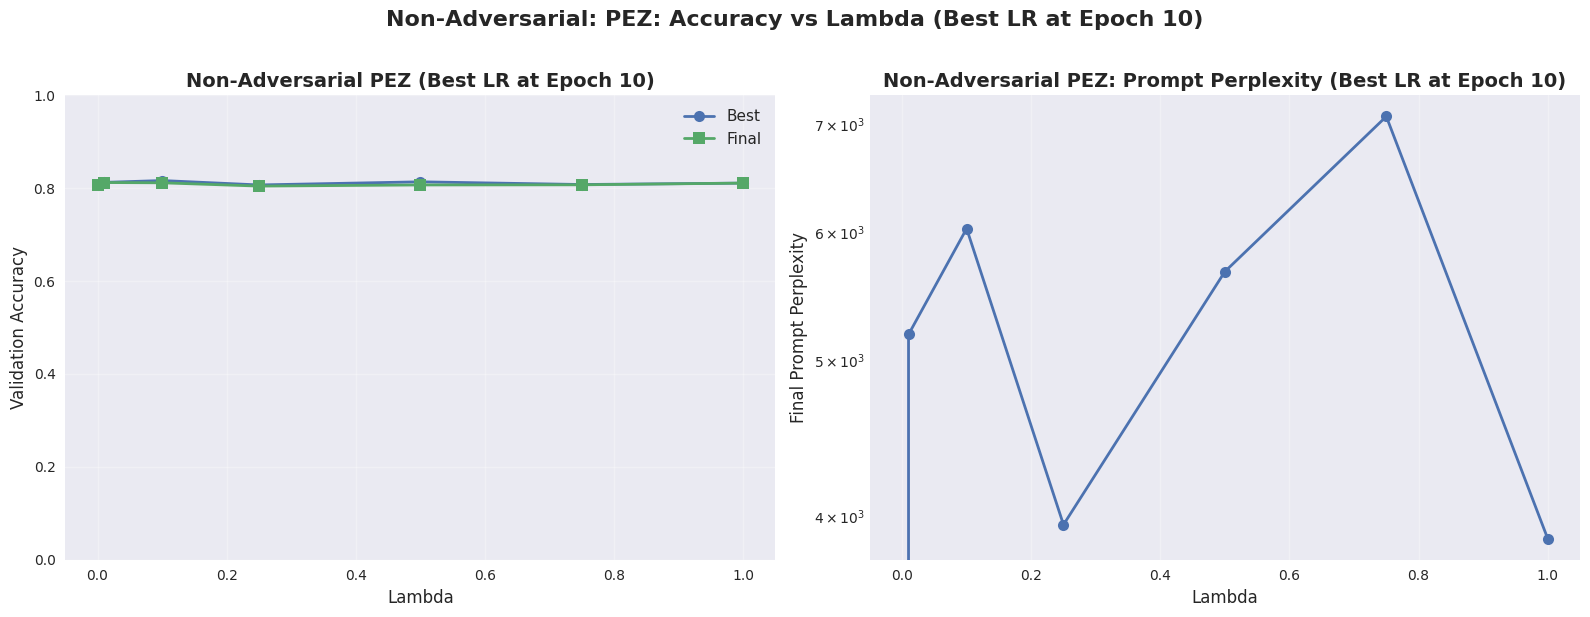

In [ ]:
# Function to plot best LR at a specific epoch
def plot_best_lr_at_epoch(histories, epoch_num, title_prefix="", is_adversarial=False):
    """Plot accuracy vs lambda using the best LR at a specific epoch.
    
    Args:
        histories: Dictionary of histories with keys (lambda, lr, prompt_length)
        epoch_num: Epoch number to use for selecting best LR (1-indexed)
        title_prefix: Prefix for plot titles
        is_adversarial: If True, this is adversarial data (for labeling)
    """
    
    if not histories:
        print("No histories to plot")
        return None
    
    # Group by lambda
    lambda_values = sorted(set(k[0] for k in histories.keys()))
    
    # For each lambda, find the LR with best accuracy at the specified epoch
    best_accs = []
    final_accs = []
    selected_lrs = []
    
    print(f"\n{'Adversarial' if is_adversarial else 'Non-Adversarial'}: Selecting best LR for each lambda (based on accuracy at epoch {epoch_num}):")
    
    for lam in lambda_values:
        # Get all histories for this lambda (across all prompt lengths and LRs)
        lam_histories = {(lam_val, lr, pl): h for (lam_val, lr, pl), h in histories.items() if lam_val == lam}
        
        # Find the best LR based on accuracy at the specified epoch
        best_key = None
        best_acc_at_epoch = -1
        
        for (lam_val, lr, pl), history in lam_histories.items():
            if 'val_acc' in history and len(history['val_acc']) >= epoch_num:
                acc_at_epoch = history['val_acc'][epoch_num - 1]  # epoch_num is 1-indexed
                if acc_at_epoch > best_acc_at_epoch:
                    best_acc_at_epoch = acc_at_epoch
                    best_key = ((lam_val, lr, pl), history)
        
        if best_key is not None:
            (lam_val, lr, pl), history = best_key
            best_accs.append(max(history['val_acc']))
            final_accs.append(history['val_acc'][-1])
            selected_lrs.append(lr)
            print(f"  Lambda {lam}: LR={lr:.0e}, prompt_length={pl} (acc at epoch {epoch_num}={best_acc_at_epoch:.4f}, final acc={history['val_acc'][-1]:.4f})")
        else:
            # If no history has enough epochs, skip this lambda
            print(f"  Lambda {lam}: No history with {epoch_num} epochs found")
            continue
    
    # Filter out lambdas that didn't have enough epochs
    valid_lambdas = [lam for i, lam in enumerate(lambda_values) if i < len(selected_lrs)]
    best_accs = best_accs[:len(valid_lambdas)]
    final_accs = final_accs[:len(valid_lambdas)]
    selected_lrs = selected_lrs[:len(valid_lambdas)]
    
    if not valid_lambdas:
        print("No valid data to plot")
        return None
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{title_prefix}PEZ: Accuracy vs Lambda (Best LR at Epoch {epoch_num})', fontsize=16, fontweight='bold', y=1.02)
    
    # Plot 1: Accuracy vs Lambda
    ax1 = axes[0]
    ax1.plot(valid_lambdas, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax1.plot(valid_lambdas, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax1.set_xlabel('Lambda', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title(f"{'Adversarial' if is_adversarial else 'Non-Adversarial'} PEZ (Best LR at Epoch {epoch_num})", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot 2: Prompt Perplexity vs Lambda
    ax2 = axes[1]
    final_ppls = []
    # Need to find the matching history for each lambda and LR
    for lam, lr in zip(valid_lambdas, selected_lrs):
        # Find the history with this lambda and LR (may have multiple prompt lengths, take first)
        matching_histories = [(k, h) for k, h in histories.items() if k[0] == lam and k[1] == lr]
        if matching_histories:
            history = matching_histories[0][1]  # Take first match
            if history and 'prompt_ppl_ppx' in history:
                final_ppls.append(history['prompt_ppl_ppx'][-1])
            else:
                final_ppls.append(None)
        else:
            final_ppls.append(None)
    
    ax2.plot(valid_lambdas, final_ppls, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('Lambda', fontsize=12)
    ax2.set_ylabel('Final Prompt Perplexity', fontsize=12)
    ax2.set_title(f"{'Adversarial' if is_adversarial else 'Non-Adversarial'} PEZ: Prompt Perplexity (Best LR at Epoch {epoch_num})", fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    return fig

# Plot non-adversarial: best LR at epoch 10
print("\n" + "=" * 80)
print("NON-ADVERSARIAL: Best LR at Epoch 10")
print("=" * 80)
if non_adv_histories:
    fig_non_adv = plot_best_lr_at_epoch(non_adv_histories, epoch_num=10, title_prefix="Non-Adversarial: ", is_adversarial=False)
    if fig_non_adv:
        plt.show()
else:
    print("No non-adversarial histories found")



Loading adversarial histories...
Loaded: lambda=1.0, lr=0.001
Loaded: lambda=1.0, lr=0.1
Loaded: lambda=1.0, lr=1e-06
Adversarial: 3 runs

ADVERSARIAL: Best LR at Epoch 5

Adversarial: Selecting best LR for each lambda (based on accuracy at epoch 5):
  Lambda 1.0: LR=1e-03 (acc at epoch 5=0.6223, final acc=0.6217)


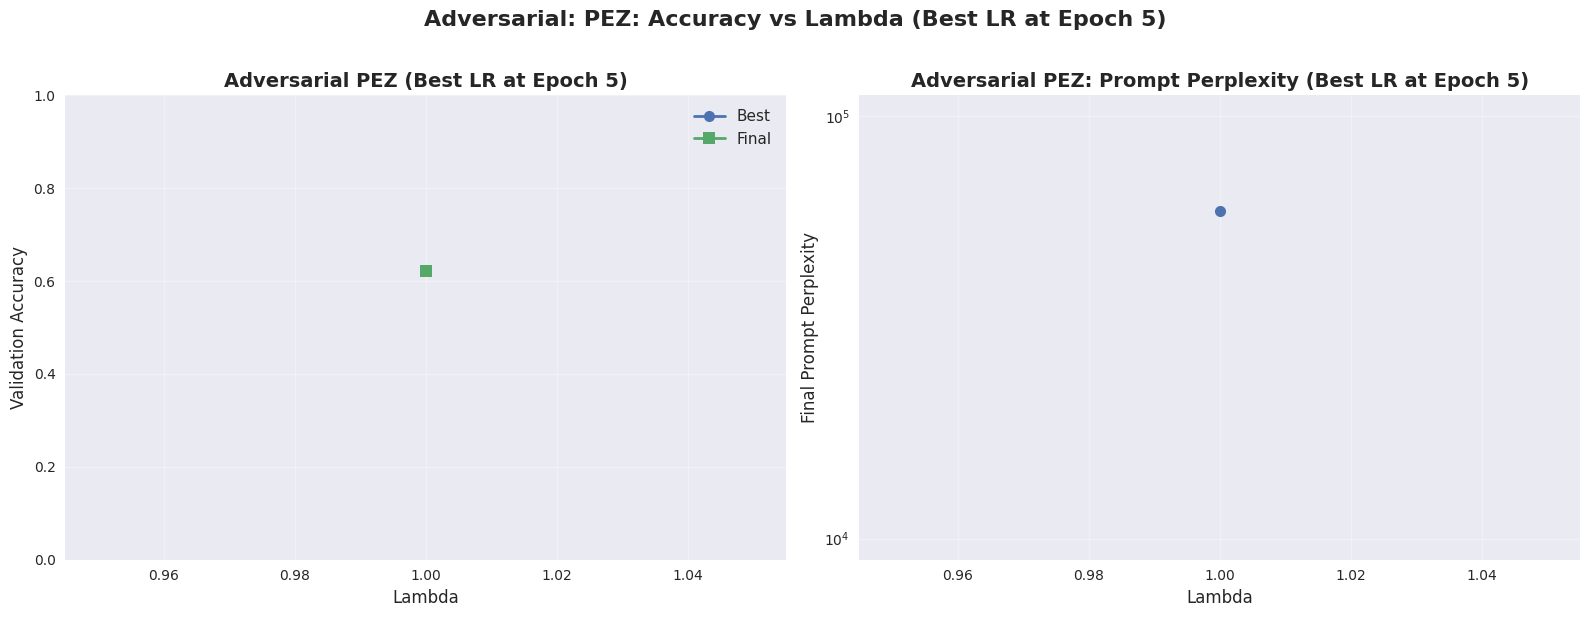

In [ ]:
# Plot adversarial: best LR at epoch 5 (or specified epoch)
if adv_histories:
    print("\n" + "=" * 80)
    print("ADVERSARIAL: Best LR at Epoch 5")
    print("=" * 80)
    fig_adv = plot_best_lr_at_epoch(adv_histories, epoch_num=5, title_prefix="Adversarial: ", is_adversarial=True)
    if fig_adv:
        plt.show()
else:
    print("\nNo adversarial histories found. Skipping adversarial plots.")
